In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

In [2]:
#movielens-20m-dataset
path='Dataset/'
movies=pd.read_csv(path+'movie.csv')
tags=pd.read_csv(path+'tag.csv')
ratings=pd.read_csv(path+'rating.csv')

In [3]:
movies['genres']=movies['genres'].str.replace('|',' ')

C:\Users\AYUSH-PC\AppData\Local\Temp\ipykernel_12608\2665461764.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['genres']=movies['genres'].str.replace('|',' ')


In [4]:
#filter ratings to user_ratings that have rated more than 55 movies otherwise it will be impossible to pivot the df later 
ratings_f=ratings.groupby('userId').filter(lambda x:len(x) >=55)
#list the movie title that filter out 
movie_list_rating=ratings_f.movieId.unique().tolist()

In [5]:
#filter the movie df
movies=movies[movies.movieId.isin(movie_list_rating)]

In [6]:
#map movie to id 
Mapping_file=dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [7]:
tags.drop(['timestamp'],1,inplace=True)

C:\Users\AYUSH-PC\AppData\Local\Temp\ipykernel_12608\1782613304.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  tags.drop(['timestamp'],1,inplace=True)


In [ ]:
ratings_f.drop(['timestamp'],1,inplace=True)

Merge movies & tags df and create a metadata tag for each movies :

In [9]:
#create a mixe df of title & genres and tags
mixed=pd.merge(movies,tags,on='movieId',how='left')

In [10]:
#creating metadata from tags & genres
mixed.fillna("",inplace=True)
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))

Final=pd.merge(movies,mixed,on='movieId',how='left')
Final['metadata'] =Final[['tag','genres']].apply(lambda x: ' '.join(x),axis =1)

Creating A Content Latent Matrix From Movie Metadata :

tf-idf vectors and truncated SVD :

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(Final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(),index=Final.index.tolist())

In [12]:
#compressed_with_SVD
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=200)
latent_matrix=svd.fit_transform(tfidf_df)
latent_matrix_df=pd.DataFrame(latent_matrix,index=Final.title.tolist())

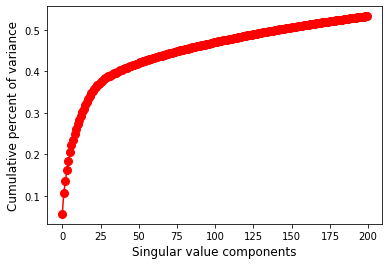

In [13]:
#plot var explained to see what latent dimensions to use 
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('Singular value components',fontsize=12)
plt.ylabel('Cumulative percent of variance',fontsize=12)
plt.show()
#As From Plot first 200 components explain over 50% of the variance  

 Creating Collabrative Latent Matrix From User Ratings :

In [14]:
ratings_f1=pd.merge(movies[['movieId']],ratings_f,on='movieId',how='right')

In [15]:
ratings_f2=ratings_f1.pivot(index='movieId',columns='userId',values='rating').fillna(0)

In [16]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=200)
latent_matrix_2=svd.fit_transform(ratings_f2)
latent_matrix_2_df=pd.DataFrame(latent_matrix_2,index=Final.title.tolist())

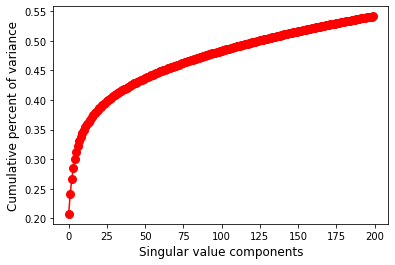

In [17]:
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('Singular value components',fontsize=12)
plt.ylabel('Cumulative percent of variance',fontsize=12)
plt.show()

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
#take the latent vectors for a selected movie from both content & collabrative matrixes 
a_1=np.array(latent_matrix_df.loc['Godzilla (Gojira) (1954)']).reshape(1,-1)
a_2=np.array(latent_matrix_2_df.loc['Godzilla (Gojira) (1954)']).reshape(1,-1)
#calculate similarity of this movie with others 
score_1=cosine_similarity(latent_matrix_df,a_1).reshape(-1)
score_2=cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)
#an average measure of both content & collabrative
hybrid=((score_1+score_2)/2.0)
#forming df of similar movies
dictDf={'content':score_1,'collabrative':score_2,'hybrid':hybrid}
similar=pd.DataFrame(dictDf,index=latent_matrix_df.index)
#sorting it on basis of hybrid value
similar.sort_values('hybrid',ascending=False,inplace=True)
similar[1:].head(10)

,content,collabrative,hybrid
King Kong vs. Godzilla (Kingukongu tai Gojira) (1962),0.786091,0.943737,0.864914
Them! (1954),0.594280,0.914934,0.754607
It Came from Beneath the Sea (1955),0.659084,0.836219,0.747651
King Kong (1933),0.641022,0.827287,0.734154
"Blob, The (1958)",0.583370,0.879643,0.731507
King Kong (1976),0.627656,0.795957,0.711807
"Godzilla, King of the Monsters! (Kaijû-ô Gojira) (1956)",0.725078,0.692670,0.708874
King Kong Lives (1986),0.714219,0.641896,0.678057
Son of Godzilla (Kaijûtô no kessen: Gojira no musuko) (1967),0.802480,0.551211,0.676846
Empire of the Ants (1977),0.745725,0.591912,0.668818


In [19]:
#storing the latent matrices
pickle.dump(latent_matrix_df,open('content.pkl','wb'))
pickle.dump(latent_matrix_2_df,open('collabrative.pkl','wb'))